# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [3]:
# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Evaluating the training procedure presents challenges stemming from several factors:

1. **Limited Training Dataset Size**:
    With just 100 samples selected from a pool of 50,000 training images, there's an inherent imbalance in class representation. This discrepancy can lead to certain classes being underrepresented, potentially skewing the model's understanding. Even while avoiding the extreme scenario of omitting entire classes from training, ensuring a balanced representation remains crucial.

    To address this issue, careful selection of data samples is imperative. We must ensure that the chosen samples adequately represent the various classes present in the CIFAR-10 dataset. Resampling techniques offer a solution by either downsampling or oversampling data. Methods such as RandomUnderSampler and RandomOverSampler, available in libraries like imbalanced-learn, can help rectify class imbalances, fostering a more equitable training environment.

2. **Proneness to Overfitting**:
    Training on a small dataset heightens the risk of overfitting, wherein the model memorizes training samples rather than generalizing patterns. Consequently, performance on the test dataset may suffer, as the model struggles to extrapolate beyond its narrow training scope.

    Data augmentation techniques can artificially expand the training dataset by applying transformations like rotation, scaling, and flipping to existing samples, fostering robustness and diversity in the model's learning process. Additionally, leveraging weak supervision techniques can augment the labeled dataset. Methods such as semi-supervised and self-supervised learning enable the utilization of unlabeled data, expanding the training dataset and potentially enhancing model performance. By iteratively labeling subsets of unlabeled data and incorporating them into training, we can enrich the model's understanding and mitigate the limitations imposed by a constrained training dataset.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [4]:
# Source of the following code: https://github.com/kuangliu/pytorch-cifar

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [7]:
def run_epoch(model, data_loader, loss_fn, opt, device, is_train=True, scheduler=None, verbose=True):
    """
    Runs a training or evaluation epoch.
    
    Args:
        model (torch.nn.Module): The model to train or evaluate.
        data_loader (torch.utils.data.DataLoader): The DataLoader for input data.
        loss_fn (callable): The loss function.
        opt (torch.optim.Optimizer): The optimizer for training.
        device (torch.device): The device to run the model on.
        is_train (bool): Specifies if the model should be in training mode.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        verbose (bool): If True, prints progress using tqdm.
        
    Returns:
        tuple: Mean loss and accuracy for the epoch.
    """
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_corrects = 0
    
    for inputs, labels in tqdm(data_loader, disable=not verbose):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            if is_train:
                opt.zero_grad()
                loss.backward()
                opt.step()
                if scheduler is not None:
                    scheduler.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        total_corrects += torch.sum(preds == labels.data)
    
    mean_loss = total_loss / len(data_loader.dataset)
    mean_accuracy = total_corrects.double() / len(data_loader.dataset)
    
    return mean_loss, mean_accuracy

def train_and_test(model, train_loader, test_loader, loss_fn, opt, device, epochs=10, scheduler=None, verbose=True):
    """
    Trains and evaluates a model.
    
    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (torch.utils.data.DataLoader): The DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): The DataLoader for test data.
        loss_fn (callable): The loss function.
        opt (torch.optim.Optimizer): The optimizer for training.
        device (torch.device): The device to run the model on.
        epochs (int): Number of training epochs.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        verbose (bool): If True, prints progress and results.
        
    Returns:
        dict: A dictionary containing training and test losses and accuracies.
    """
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(epochs):
        if verbose: print(f'Epoch {epoch+1}/{epochs}')
        
        # Run training epoch
        train_loss, train_acc = run_epoch(model, train_loader, loss_fn, opt, device, is_train=True, scheduler=scheduler, verbose=verbose)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Run evaluation epoch
        test_loss, test_acc = run_epoch(model, test_loader, loss_fn, opt, device, is_train=False, verbose=verbose)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        if verbose:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    if verbose: print('Finished Training')
    
    return history


In [33]:
# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 10

# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Storage of the results for ResNet18 model
resnet18_train_acc = history['train_acc']
resnet18_test_acc = history['test_acc']

resnet18_train_acc = [tensor.cpu().numpy() for tensor in resnet18_train_acc]
resnet18_train_acc = np.array(resnet18_train_acc)

resnet18_test_acc = [tensor.cpu().numpy() for tensor in resnet18_test_acc]
resnet18_test_acc = np.array(resnet18_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 68.25it/s]


Epoch 1/10, Train Loss: 2.9490, Train Acc: 0.1700, Test Loss: 7.5198, Test Acc: 0.0739
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 68.78it/s]


Epoch 2/10, Train Loss: 2.3874, Train Acc: 0.2000, Test Loss: 4.6420, Test Acc: 0.0539
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


Epoch 3/10, Train Loss: 1.9685, Train Acc: 0.3200, Test Loss: 3.0744, Test Acc: 0.1863
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 68.87it/s]


Epoch 4/10, Train Loss: 1.6861, Train Acc: 0.4000, Test Loss: 2.3786, Test Acc: 0.1979
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 68.91it/s]


Epoch 5/10, Train Loss: 1.6251, Train Acc: 0.4400, Test Loss: 2.2361, Test Acc: 0.2048
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 68.87it/s]


Epoch 6/10, Train Loss: 1.5448, Train Acc: 0.5000, Test Loss: 2.1725, Test Acc: 0.2123
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 68.92it/s]


Epoch 7/10, Train Loss: 1.5778, Train Acc: 0.5000, Test Loss: 2.1736, Test Acc: 0.2141
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 68.85it/s]


Epoch 8/10, Train Loss: 1.4665, Train Acc: 0.5400, Test Loss: 2.1674, Test Acc: 0.2137
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


Epoch 9/10, Train Loss: 1.4893, Train Acc: 0.5200, Test Loss: 2.1694, Test Acc: 0.2140
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 69.03it/s]

Epoch 10/10, Train Loss: 1.4314, Train Acc: 0.5900, Test Loss: 2.1615, Test Acc: 0.2151
Finished Training
Test loss: 2.1615, Test accuracy: 0.2151


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 10 | 59.00% | 21.51% |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [39]:
from torchvision.models import resnet18, ResNet18_Weights # We chose the ResNet18 for comparison sake

# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 10

# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)
# Adapt it for CIFAR10
model.fc = nn.Linear(512, 10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Sotrage of the results for Pre-trained ResNet18 model
pretrained_resnet18_train_acc = history['train_acc']
pretrained_resnet18_test_acc = history['test_acc']

pretrained_resnet18_train_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_train_acc]
pretrained_resnet18_train_acc = np.array(pretrained_resnet18_train_acc)

pretrained_resnet18_test_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_test_acc]
pretrained_resnet18_test_acc = np.array(pretrained_resnet18_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 98.69it/s]


Epoch 1/10, Train Loss: 2.9863, Train Acc: 0.2200, Test Loss: 2.7933, Test Acc: 0.1611
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 99.07it/s]


Epoch 2/10, Train Loss: 2.1128, Train Acc: 0.4000, Test Loss: 2.7232, Test Acc: 0.1986
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 99.25it/s]


Epoch 3/10, Train Loss: 1.3159, Train Acc: 0.5800, Test Loss: 3.2238, Test Acc: 0.2184
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 99.05it/s]


Epoch 4/10, Train Loss: 0.9146, Train Acc: 0.6500, Test Loss: 2.6006, Test Acc: 0.2548
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 99.10it/s]


Epoch 5/10, Train Loss: 0.7688, Train Acc: 0.7400, Test Loss: 2.5253, Test Acc: 0.2528
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 99.19it/s]


Epoch 6/10, Train Loss: 0.6539, Train Acc: 0.7800, Test Loss: 2.5575, Test Acc: 0.2581
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 99.34it/s]


Epoch 7/10, Train Loss: 0.7191, Train Acc: 0.7500, Test Loss: 2.5289, Test Acc: 0.2625
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 99.41it/s]


Epoch 8/10, Train Loss: 0.5063, Train Acc: 0.8400, Test Loss: 2.5284, Test Acc: 0.2604
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 99.29it/s]


Epoch 9/10, Train Loss: 0.5110, Train Acc: 0.8500, Test Loss: 2.5487, Test Acc: 0.2646
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 99.02it/s]

Epoch 10/10, Train Loss: 0.5808, Train Acc: 0.8400, Test Loss: 2.5397, Test Acc: 0.2636
Finished Training
Test loss: 2.5397, Test accuracy: 0.2636


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Pre-trained ResNet18  | 10 | 84.00% | 26.36% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

When dealing with translations, rotations, scaling effects, and color changes on 32x32 images, several issues may arise:

- **Loss of Information**: These transformations can potentially lead to a loss of important information in the image, especially when dealing with rotations or scaling effects. This loss of information can hinder the model's ability to learn meaningful features from the data.

- **Boundary Artifacts**: Translations, rotations, and scaling effects can result in boundary artifacts, where parts of the image may be cut off or distorted, particularly along the edges of the image.

- **Aliasing**: When scaling down or rotating images, aliasing artifacts may occur, leading to a loss of image quality and introducing unwanted high-frequency noise.

- **Color Distortion**: Changes in color, brightness, or contrast can alter the appearance of objects in the image, potentially making it difficult for the model to generalize across different color distributions.



To tackle these issues, several ideas can be considered:

- **Padding**: Apply padding to the image before performing transformations to mitigate boundary artifacts. Padding ensures that no information is lost at the edges of the image during transformations.

- **Interpolation**: Use appropriate interpolation methods when scaling images to reduce aliasing artifacts and maintain image quality.

- **Anti-Aliasing Filters**: When downsampling an image, it's common to apply an anti-aliasing filter to mitigate aliasing artifacts. Conversely, when upsampling an image, a reconstruction filter is typically employed in place of the anti-aliasing filter to ensure smoothness and preserve image quality.

- **Normalization**: Normalize the color channels of the images to a standard range before applying color changes. This can help ensure that color transformations do not disproportionately affect certain channels or introduce unrealistic color distributions.

- **Quality Control**: Regularly inspect augmented images to ensure that transformations are applied appropriately and do not introduce unrealistic variations or distortions that could adversely affect model performance.

- **Data Augmentation**: Augment the training data with a diverse set of transformations, but ensure that the transformations are applied judiciously to avoid excessive distortion or loss of information. For example, limit the range of rotation angles or scaling factors to retain semantic content. We could even consider **Adaptive Augmentation**: Apply data augmentation techniques adaptively based on the specific characteristics of the dataset. For instance, consider applying less aggressive transformations to images with complex content or fine details. Finally, **Domain-specific Augmentation**: Tailor data augmentation techniques to the characteristics of the target domain. For example, when dealing with medical images, consider incorporating domain-specific knowledge to guide the augmentation process and ensure that clinically relevant features are preserved.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

- **RandomHorizontalFlip**: Flips images horizontally with a probability of 0.5, effectively increasing the diversity of object orientations in the dataset, which is beneficial for tasks where object orientation is not critical.

- **RandomVerticalFlip**: Similar to horizontal flipping but in the vertical direction, it ensures that the model learns to recognize objects from different perspectives, further enhancing its ability to generalize.

- **RandomRotation(degrees=15)**: Randomly rotates images by up to 15 degrees in both clockwise and counterclockwise directions. This variation simulates real-world scenarios where objects may be tilted or rotated, encouraging the model to learn features invariant to rotation.

- **RandomResizedCrop(32, scale=(0.8, 1.0))**: Randomly crops and resizes images to a size of 32x32 pixels, with a scale factor ranging from 0.8 to 1.0. This transformation helps the model focus on different parts of the image while preserving spatial relationships, aiding in robust feature learning.

- **ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)**: Randomly adjusts brightness, contrast, saturation, and hue of the images, introducing variations in color distribution. This ensures that the model learns to recognize objects under different lighting conditions and color variations, making it more adaptable to real-world scenarios.

In [59]:
# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 10

# Define additional geometric transformations. Best combination found so far: RandomHorizontalFlip and RandomResizedCrop(32, scale=(0.8, 1.0))
additional_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # transforms.RandomVerticalFlip(),  # Random vertical flip
    # transforms.RandomRotation(degrees=15),   # Random rotation up to 15 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
])

# Load training dataset with additional transformations
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    additional_transforms,
]))
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Storage of the results for the ResNet18 after Data Augmentation model
resnet18_augmented_train_acc = history['train_acc']
resnet18_augmented_test_acc = history['test_acc']

resnet18_augmented_train_acc = [tensor.cpu().numpy() for tensor in resnet18_augmented_train_acc]
resnet18_augmented_train_acc = np.array(resnet18_augmented_train_acc)

resnet18_augmented_test_acc = [tensor.cpu().numpy() for tensor in resnet18_augmented_test_acc]
resnet18_augmented_test_acc = np.array(resnet18_augmented_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 70.25it/s]


Epoch 1/10, Train Loss: 2.9857, Train Acc: 0.1400, Test Loss: 10.6465, Test Acc: 0.1000
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 70.76it/s]


Epoch 2/10, Train Loss: 2.2320, Train Acc: 0.2200, Test Loss: 5.0169, Test Acc: 0.1060
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 70.67it/s]


Epoch 3/10, Train Loss: 1.9616, Train Acc: 0.2900, Test Loss: 2.4529, Test Acc: 0.1644
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 70.69it/s]


Epoch 4/10, Train Loss: 1.6794, Train Acc: 0.4000, Test Loss: 2.2431, Test Acc: 0.1941
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 69.56it/s]


Epoch 5/10, Train Loss: 1.6540, Train Acc: 0.4100, Test Loss: 2.1417, Test Acc: 0.2347
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 70.78it/s]


Epoch 6/10, Train Loss: 1.6109, Train Acc: 0.4800, Test Loss: 2.1384, Test Acc: 0.2464
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 70.65it/s]


Epoch 7/10, Train Loss: 1.4056, Train Acc: 0.5300, Test Loss: 2.1241, Test Acc: 0.2491
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 70.56it/s]


Epoch 8/10, Train Loss: 1.4528, Train Acc: 0.5200, Test Loss: 2.1228, Test Acc: 0.2509
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 70.07it/s]


Epoch 9/10, Train Loss: 1.5532, Train Acc: 0.5000, Test Loss: 2.1310, Test Acc: 0.2503
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 70.50it/s]

Epoch 10/10, Train Loss: 1.4676, Train Acc: 0.5600, Test Loss: 2.1267, Test Acc: 0.2509
Finished Training
Test loss: 2.1267, Test accuracy: 0.2509


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 after Data Augmentation | 10 | 56.00% | 25.09% |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

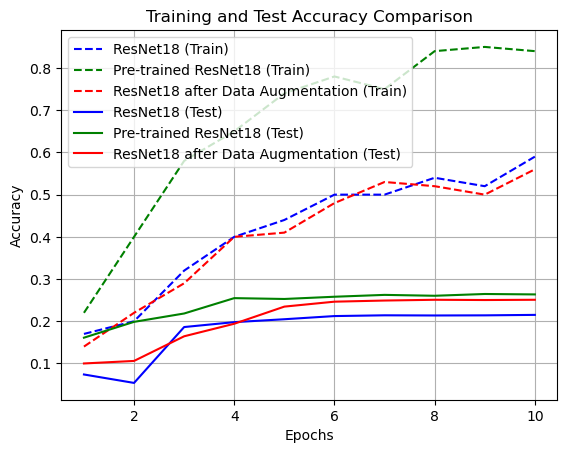

In [89]:
epochs = range(1, 11)

# Plot training accuracy
plt.plot(epochs, resnet18_train_acc, linestyle='--', label='ResNet18 (Train)', color='b')
plt.plot(epochs, pretrained_resnet18_train_acc, linestyle='--', label='Pre-trained ResNet18 (Train)', color='g')
plt.plot(epochs, resnet18_augmented_train_acc, linestyle='--', label='ResNet18 after Data Augmentation (Train)', color='r')

# Plot test accuracy
plt.plot(epochs, resnet18_test_acc, label='ResNet18 (Test)', color='b')
plt.plot(epochs, pretrained_resnet18_test_acc, label='Pre-trained ResNet18 (Test)', color='g')
plt.plot(epochs, resnet18_augmented_test_acc, label='ResNet18 after Data Augmentation (Test)', color='r')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Pre-trained ResNet18  | 10 | 84.00% | 26.36% |
|   ResNet18 after Data Augmentation | 10 | 56.00% | 25.09% |
|   ResNet18  | 10 | 59.00% | 21.51% |

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.